<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/results_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import os
import sys
import shutil
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive
from sklearn.metrics import roc_auc_score
import subprocess

In [66]:
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-11.2

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-11.2


In [67]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
!nvidia-smi

Fri Nov 18 14:35:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [69]:
!pip install astro-datasets --upgrade
!pip install tensorflow_datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
# https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl
!pip install jax==0.2.12
!pip install dm-haiku==0.0.5.dev0 optax==0.0.6 chex==0.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl (189.4 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
shutil.rmtree('bnn_hmc', ignore_errors=True)

In [72]:
!git clone https://github.com/adammoss/bnn_hmc

Cloning into 'bnn_hmc'...
remote: Enumerating objects: 1428, done.
remote: Counting objects: 100% (425/425), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 1428 (delta 289), reused 367 (delta 236), pack-reused 1003
Receiving objects: 100% (1428/1428), 1.67 MiB | 20.66 MiB/s, done.
Resolving deltas: 100% (969/969), done.


In [73]:
!cd bnn_hmc && git checkout plot_posterior

Branch 'plot_posterior' set up to track remote branch 'plot_posterior' from 'origin'.
Switched to a new branch 'plot_posterior'


In [74]:
class Analyse:

  def __init__(self, root, dataset, method):
    dirs = glob.glob(root + '/runs/' + method + '/' + dataset +  '/*/')
    accuracy = []
    nll = []
    ece = []
    rmse = []
    mae = []
    auc = []
    ood_accuracy = []
    ood_nll = []
    ood_ece = []
    ood_rmse = []
    ood_mae = []
    ood_auc = []
    best_model = []
    for dir in dirs:
      if method in ['vi', 'mcd']:
        files = glob.glob(dir + '/*/ensemble_prediction*')
      elif method == 'sgd':
        files = glob.glob(dir + '/*/*/ensemble_prediction*')
      if len(files) != 1:
        raise ValueError
      dir = '/'.join(files[0].split('/')[:-1])
      ensemble_metrics = np.load(glob.glob(os.path.join(dir, 'e*metric*'))[0], allow_pickle=True)
      test_set = np.squeeze(np.load(glob.glob(os.path.join(dir, 'test_set*'))[0]))
      ensemble_predictions = np.squeeze(np.load(glob.glob(os.path.join(dir, 'e*prediction*'))[0]))
      if 'accuracy' in ensemble_metrics.item():
        accuracy.append(ensemble_metrics.item()['accuracy'])
        ece.append(ensemble_metrics.item()['ece'])
        classification = True
        num_classes = ensemble_predictions.shape[1]
        targets = np.eye(num_classes)[test_set]
        auc.append(roc_auc_score(targets, ensemble_predictions))
      else:
        rmse.append(ensemble_metrics.item()['rmse'])
        classification = False
        mae.append(np.mean(np.abs(ensemble_predictions[:,0] - test_set[:])))
        #plt.errorbar(test_set[:], ensemble_predictions[:,0], yerr=ensemble_predictions[:,1], ls='none')
        #plt.show()
      nll.append(ensemble_metrics.item()['nll'])
      best_model += glob.glob(os.path.join(dir, 'model_best.pt'))

      try:
        ood_ensemble_metrics = np.load(glob.glob(os.path.join(dir, 'ood*metric*'))[0], allow_pickle=True)
      except:
        ood_ensemble_metrics = None
      if ood_ensemble_metrics is not None:
        ood_test_set = np.squeeze(np.load(glob.glob(os.path.join(dir, 'ood*test_set*'))[0]))
        ood_ensemble_predictions = np.squeeze(np.load(glob.glob(os.path.join(dir, 'ood*en*prediction*'))[0]))
        if 'accuracy' in ood_ensemble_metrics.item():
          ood_accuracy.append(ood_ensemble_metrics.item()['accuracy'])
          ood_ece.append(ood_ensemble_metrics.item()['ece'])
          ood_classification = True
          ood_num_classes = ood_ensemble_predictions.shape[1]
          ood_targets = np.eye(num_classes)[ood_test_set]
          ood_auc.append(roc_auc_score(ood_targets, ood_ensemble_predictions))
        else:
          ood_rmse.append(ood_ensemble_metrics.item()['rmse'])
          ood_classification = False
          ood_mae.append(np.mean(np.abs(ood_ensemble_predictions[:,0] - ood_test_set[:])))
          #plt.errorbar(ood_test_set[:], ood_ensemble_predictions[:,0], yerr=ood_ensemble_predictions[:,1], ls='none')
          #plt.show()
        ood_nll.append(ood_ensemble_metrics.item()['nll'])

    print('Mean, std nll:', np.mean(nll), np.std(nll))
    print(nll)
    if classification:
      print('Mean, std accuracy:', np.mean(accuracy), np.std(accuracy))
      print('Mean, std ECE:', np.mean(ece), np.std(ece))
      print('Mean, std AUC:', np.mean(auc), np.std(auc))
    else:
      print('Mean, std RMSE:', np.mean(rmse), np.std(rmse))
      print('Mean, std MAE:', np.mean(mae), np.std(mae))

    print('OOD Mean, std nll:', np.mean(ood_nll), np.std(ood_nll))
    if classification:
      print('OOD Mean, std accuracy:', np.mean(ood_accuracy), np.std(ood_accuracy))
      print('OOD Mean, std ECE:', np.mean(ood_ece), np.std(ood_ece))
      print('OOD Mean, std AUC:', np.mean(ood_auc), np.std(ood_auc))
    else:
      print('OOD Mean, std RMSE:', np.mean(ood_rmse), np.std(ood_rmse))
      print('OOD Mean, std MAE:', np.mean(ood_mae), np.std(ood_mae))

    self.best_model = best_model


In [75]:
Analyse('/content/drive/MyDrive/bnn_results4', 'mirabest/confident', 'vi')

Mean, std nll: 0.24429865 0.017628966
[0.234675, 0.26902804, 0.22919288]
Mean, std accuracy: 0.89743596 0.016343
Mean, std ECE: 0.05894014086478796 0.00907933273750058
Mean, std AUC: 0.9669758812615955 0.006928615250048689
OOD Mean, std nll: 0.915706 0.018178225
OOD Mean, std accuracy: 0.6530612 0.016663186
OOD Mean, std ECE: 0.21839887349783968 0.023385840761520137
OOD Mean, std AUC: 0.6838888888888889 0.008314794192830995


In [76]:
ra = Analyse('/content/drive/MyDrive/bnn_results4', 'mirabest/confident', 'sgd')

Mean, std nll: 0.21311915 0.015662044
[0.23483269, 0.20604926, 0.19847545]
Mean, std accuracy: 0.9070513 0.011992511
Mean, std ECE: 0.0669620133554324 0.0061246756119942855
Mean, std AUC: 0.976252319109462 0.004165110263570222
OOD Mean, std nll: 0.97117907 0.098817885
OOD Mean, std accuracy: 0.6530612 0.028861487
OOD Mean, std ECE: 0.22127578706562923 0.01724063509770188
OOD Mean, std AUC: 0.7094444444444444 0.004374448818895448


In [77]:
base_cmd = ['python3', 'bnn_hmc/scripts/make_posterior_surface_plot.py', '--dir=runs/sgd/mirabest/confident',
'--dataset_name=mirabest/confident', '--model_name=lenet', '--grid_size=100',
'--image_size=64', '--train_split=train[:90%]', '--eval_split=test',
'--checkpoint1=%s' % ra.best_model[0], 
'--checkpoint2=%s' % ra.best_model[1], 
'--checkpoint3=%s' % ra.best_model[2]]
' '.join(base_cmd)
p = subprocess.run(base_cmd, capture_output=True)
print(p.stdout.decode('utf8'))

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Namespace(builder_kwargs=None, checkpoint1='/content/drive/MyDrive/bnn_results4/runs/sgd/mirabest/confident/2/4/sgd__opt_sgd_0.9__lr_sch_i_3e-07___epochs_300_wd_10_batchsize_53_temp_1.0__seed_14/model_best.pt', checkpoint2='/content/drive/MyDrive/bnn_results4/runs/sgd/mirabest/confident/1/4/sgd__opt_sgd_0.9__lr_sch_i_3e-07___epochs_300_wd_10_batchsize_53_temp_1.0__seed_9/model_best.pt', checkpoint3='/content/drive/MyDrive/bnn_results4/runs/sgd/mirabest/confident/0/4/sgd__opt_sgd_0.9__lr_sch_i_3e-07___epochs_300_wd_10_batchsize_53_temp_1.0__seed_4/model_best.pt', dataset_name='mirabest/confident', dir='runs/sgd/mirabest/confident', ensemble_exclude_metric=None, ensemble_exclude_value=1.0, ensemble_root=None, eval_split='test', grid_size=100, image_size=64, init_checkpoint=None, limit_bottom=-0.75, limit_left=-0.75, limit_rig

In [78]:
d = np.load('/content/runs/sgd/mirabest/confident/posterior_visualization/surface_plot.npz')
log_probs = d['log_probs']
log_likelihoods = d['log_likelihoods']
grid = d['grid']
z_cut = log_likelihoods[np.isfinite(log_likelihoods)]

In [79]:
np.max(z_cut) 

-53.54815673828125

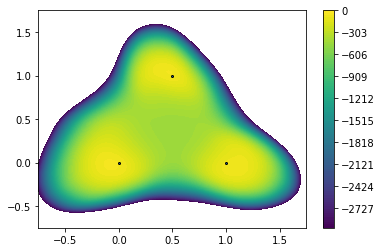

In [80]:
levels = np.linspace(-3000, -0, 100)
plt.contourf(grid[:,:,0], grid[:,:,1], log_likelihoods, levels=levels)
plt.plot([0., 1., 0.5], [0., 0., 1.], "o", ms=2, markeredgecolor="k")
plt.colorbar()
plt.show()

In [81]:
Analyse('/content/drive/MyDrive/bnn_results4', 'mirabest/confident', 'mcd')

Mean, std nll: 0.33196008 0.009896372
[0.33176246, 0.31993955, 0.3441782]
Mean, std accuracy: 0.86538464 0.013598231
Mean, std ECE: 0.10493433 0.004451591
Mean, std AUC: 0.9390228818800247 0.0026469925243082872
OOD Mean, std nll: 0.7837495 0.060497165
OOD Mean, std accuracy: 0.67346936 0.016663186
OOD Mean, std ECE: 0.18827839 0.018977564
OOD Mean, std AUC: 0.6711111111111111 0.034246744460938776


In [82]:
Analyse('/content/drive/MyDrive/bnn_results4', 'cmd', 'vi')

Mean, std nll: -1.372750997543335 0.06035629666110258
[-1.4084981679916382, -1.2877511978149414, -1.4220036268234253]
Mean, std RMSE: 0.06099770430638318 0.0029773118351376637
Mean, std MAE: 0.04865661 0.0028058838
OOD Mean, std nll: -1.1575834353764851 0.019672097613345162
OOD Mean, std RMSE: 0.07852634760166648 0.002375851976387673
OOD Mean, std MAE: 0.06166321 0.0013773936


In [83]:
ra = Analyse('/content/drive/MyDrive/bnn_results4', 'cmd', 'sgd')

Mean, std nll: -1.5290119250615437 0.03566489026895294
[-1.5047599077224731, -1.579437494277954, -1.502838373184204]
Mean, std RMSE: 0.051581344295004515 0.0007870756792035808
Mean, std MAE: 0.040950853 0.0010835979
OOD Mean, std nll: -0.87586325 0.2397272
OOD Mean, std RMSE: 0.081979014 0.00015028888
OOD Mean, std MAE: 0.06582836 0.00093221094


In [84]:
base_cmd = ['python3', 'bnn_hmc/scripts/make_posterior_surface_plot.py', '--dir=runs/sgd/cmd/',
'--dataset_name=cmd', '--model_name=lenet', '--grid_size=100', '--scaling=asinh',
'--builder_kwargs={"simulation": "IllustrisTNG", "field": "Mtot", "parameters": ["omegam"]}',
'--image_size=64', '--train_split=train[:90%]', '--eval_split=train[95%:]',
'--checkpoint1=%s' % ra.best_model[0], 
'--checkpoint2=%s' % ra.best_model[1], 
'--checkpoint3=%s' % ra.best_model[2]]
p = subprocess.run(base_cmd, capture_output=True)
print(p.stdout.decode('utf8'))

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Namespace(builder_kwargs='{"simulation": "IllustrisTNG", "field": "Mtot", "parameters": ["omegam"]}', checkpoint1='/content/drive/MyDrive/bnn_results4/runs/sgd/cmd/2/4/sgd__opt_sgd_0.9__lr_sch_i_1e-08___epochs_300_wd_10_batchsize_100_temp_1.0__seed_14/model_best.pt', checkpoint2='/content/drive/MyDrive/bnn_results4/runs/sgd/cmd/0/4/sgd__opt_sgd_0.9__lr_sch_i_1e-08___epochs_300_wd_10_batchsize_100_temp_1.0__seed_4/model_best.pt', checkpoint3='/content/drive/MyDrive/bnn_results4/runs/sgd/cmd/1/4/sgd__opt_sgd_0.9__lr_sch_i_1e-08___epochs_300_wd_10_batchsize_100_temp_1.0__seed_9/model_best.pt', dataset_name='cmd', dir='runs/sgd/cmd/', ensemble_exclude_metric=None, ensemble_exclude_value=1.0, ensemble_root=None, eval_split='train[95%:]', grid_size=100, image_size=64, init_checkpoint=None, limit_bottom=-0.75, limit_left=-0.75, li

In [85]:
d = np.load('/content/runs/sgd/cmd/posterior_visualization/surface_plot.npz')
log_probs = d['log_probs']
log_likelihoods = d['log_likelihoods']
grid = d['grid']
z_cut = log_likelihoods[np.isfinite(log_likelihoods)]

In [86]:
print(np.max(z_cut) / 15000)

1.5482236979166666


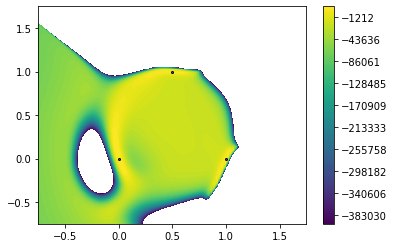

In [87]:
levels = np.linspace(-400000, 20000, 100)
plt.contourf(grid[:,:,0], grid[:,:,1], log_likelihoods, levels=levels)
plt.plot([0., 1., 0.5], [0., 0., 1.], "o", ms=2, markeredgecolor="k")
plt.colorbar()
plt.show()

In [88]:
Analyse('/content/drive/MyDrive/bnn_results4', 'cmd', 'mcd')

Mean, std nll: -1.6538066466649373 0.027239119436160725
[-1.615360975265503, -1.670931339263916, -1.675127625465393]
Mean, std RMSE: 0.050921085661624337 0.001529052148427447
Mean, std MAE: 0.039841432 0.0013411181
OOD Mean, std nll: -0.27002639571825665 0.3717282748811189
OOD Mean, std RMSE: 0.08474296981552343 0.005509459062342425
OOD Mean, std MAE: 0.0644827 0.0051137186


In [89]:
Analyse('/content/drive/MyDrive/bnn_results4', 'slc/space', 'vi')

Mean, std nll: 0.57076526 0.0076243374
[0.56092155, 0.5794979, 0.5718763]
Mean, std accuracy: 0.68931675 0.0075144637
Mean, std ECE: 0.10309401011466979 0.006363819015921188
Mean, std AUC: 0.8605233665654318 0.0020395948482515715
OOD Mean, std nll: nan nan
OOD Mean, std accuracy: nan nan
OOD Mean, std ECE: nan nan
OOD Mean, std AUC: nan nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [90]:
ra = Analyse('/content/drive/MyDrive/bnn_results4', 'slc/space', 'sgd')

Mean, std nll: 0.5219005 0.01013932
[0.51815164, 0.5357611, 0.5117888]
Mean, std accuracy: 0.7195 0.0028363692
Mean, std ECE: 0.08235779230793318 0.008641534558929954
Mean, std AUC: 0.878692435521717 0.0015284343004093998
OOD Mean, std nll: nan nan
OOD Mean, std accuracy: nan nan
OOD Mean, std ECE: nan nan
OOD Mean, std AUC: nan nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [91]:
base_cmd = ['python3', 'bnn_hmc/scripts/make_posterior_surface_plot.py', '--dir=runs/sgd/slc/space/',
'--dataset_name=slc/space', '--model_name=lenet', '--grid_size=100',
'--image_size=64', '--train_split=train[:80%]', '--eval_split=test',
'--checkpoint1=%s' % ra.best_model[0], 
'--checkpoint2=%s' % ra.best_model[1], 
'--checkpoint3=%s' % ra.best_model[2]]
p = subprocess.run(base_cmd, capture_output=True)
print(p.stdout.decode('utf8'))

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Namespace(builder_kwargs=None, checkpoint1='/content/drive/MyDrive/bnn_results4/runs/sgd/slc/space/2/4/sgd__opt_sgd_0.9__lr_sch_i_3e-07___epochs_300_wd_10_batchsize_100_temp_1.0__seed_14/model_best.pt', checkpoint2='/content/drive/MyDrive/bnn_results4/runs/sgd/slc/space/1/4/sgd__opt_sgd_0.9__lr_sch_i_3e-07___epochs_300_wd_10_batchsize_100_temp_1.0__seed_9/model_best.pt', checkpoint3='/content/drive/MyDrive/bnn_results4/runs/sgd/slc/space/0/4/sgd__opt_sgd_0.9__lr_sch_i_3e-07___epochs_300_wd_10_batchsize_100_temp_1.0__seed_4/model_best.pt', dataset_name='slc/space', dir='runs/sgd/slc/space/', ensemble_exclude_metric=None, ensemble_exclude_value=1.0, ensemble_root=None, eval_split='test', grid_size=100, image_size=64, init_checkpoint=None, limit_bottom=-0.75, limit_left=-0.75, limit_right=1.75, limit_top=1.75, model_name='lene

In [92]:
d = np.load('/content/runs/sgd/slc/space/posterior_visualization/surface_plot.npz')
log_probs = d['log_probs']
log_likelihoods = d['log_likelihoods']
grid = d['grid']
z_cut = log_likelihoods[np.isfinite(log_likelihoods)]

In [93]:
print(np.max(z_cut) / 15000)

-0.19284474283854167


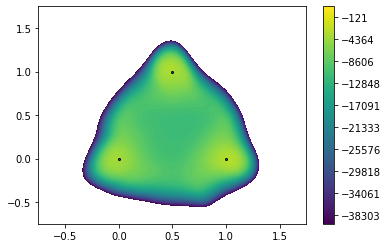

In [94]:
levels = np.linspace(-40000, 2000, 100)
plt.contourf(grid[:,:,0], grid[:,:,1], log_likelihoods, levels=levels)
plt.plot([0., 1., 0.5], [0., 0., 1.], "o", ms=2, markeredgecolor="k")
plt.colorbar()
plt.show()

In [95]:
Analyse('/content/drive/MyDrive/bnn_results4', 'slc/space', 'mcd')

Mean, std nll: 0.55310565 0.03922746
[0.52673686, 0.60855955, 0.52402073]
Mean, std accuracy: 0.7047167 0.00875455
Mean, std ECE: 0.08170188 0.020485546
Mean, std AUC: 0.8666161934128594 0.007418121130355344
OOD Mean, std nll: nan nan
OOD Mean, std accuracy: nan nan
OOD Mean, std ECE: nan nan
OOD Mean, std AUC: nan nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [96]:
Analyse('/content/drive/MyDrive/bnn_results4', 'mlsst/Y10', 'vi')

Mean, std nll: 0.7303545 0.013643114
[0.7470963, 0.7136778, 0.73028916]
Mean, std accuracy: 0.7281707 0.0011934302
Mean, std ECE: 0.03469654665776772 0.0042552583492991665
Mean, std AUC: 0.8601072446306982 0.001553659834044372
OOD Mean, std nll: 1.3624474 0.0765565
OOD Mean, std accuracy: 0.53536856 0.00548787
OOD Mean, std ECE: 0.24190705103476542 0.01822432547065041
OOD Mean, std AUC: 0.7047097885099389 0.00042827994044606244


In [97]:
ra = Analyse('/content/drive/MyDrive/bnn_results4', 'mlsst/Y10', 'sgd')

Mean, std nll: 0.7441036 0.0061378796
[0.735424, 0.7485377, 0.748349]
Mean, std accuracy: 0.68379253 0.006824745
Mean, std ECE: 0.047549211805823666 0.005562942629604232
Mean, std AUC: 0.842916828637323 0.0032653736555740614
OOD Mean, std nll: 1.0769275 0.024906585
OOD Mean, std accuracy: 0.53596425 0.005620968
OOD Mean, std ECE: 0.18594472 0.013087376
OOD Mean, std AUC: 0.7387832818204857 0.0007788339905827964


In [98]:
base_cmd = ['python3', 'bnn_hmc/scripts/make_posterior_surface_plot.py', '--dir=runs/sgd/mlsst/Y10/',
'--dataset_name=mlsst/Y10', '--model_name=lenet', '--grid_size=100', '--scaling=asinh',
'--image_size=64', '--train_split=train', '--eval_split=test',
'--checkpoint1=%s' % ra.best_model[0], 
'--checkpoint2=%s' % ra.best_model[1], 
'--checkpoint3=%s' % ra.best_model[2]]
p = subprocess.run(base_cmd, capture_output=True)
print(p.stdout.decode('utf8'))

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Namespace(builder_kwargs=None, checkpoint1='/content/drive/MyDrive/bnn_results4/runs/sgd/mlsst/Y10/2/4/sgd__opt_adam__lr_sch_i_1e-05___epochs_300_wd_10_batchsize_100_temp_1.0__seed_14/model_best.pt', checkpoint2='/content/drive/MyDrive/bnn_results4/runs/sgd/mlsst/Y10/1/4/sgd__opt_adam__lr_sch_i_1e-05___epochs_300_wd_10_batchsize_100_temp_1.0__seed_9/model_best.pt', checkpoint3='/content/drive/MyDrive/bnn_results4/runs/sgd/mlsst/Y10/0/4/sgd__opt_adam__lr_sch_i_1e-05___epochs_300_wd_10_batchsize_100_temp_1.0__seed_4/model_best.pt', dataset_name='mlsst/Y10', dir='runs/sgd/mlsst/Y10/', ensemble_exclude_metric=None, ensemble_exclude_value=1.0, ensemble_root=None, eval_split='test', grid_size=100, image_size=64, init_checkpoint=None, limit_bottom=-0.75, limit_left=-0.75, limit_right=1.75, limit_top=1.75, model_name='lenet', outpu

In [99]:
d = np.load('/content/runs/sgd/mlsst/Y10/posterior_visualization/surface_plot.npz')
log_probs = d['log_probs']
log_likelihoods = d['log_likelihoods'] / 20000
grid = d['grid']
z_cut = log_likelihoods[np.isfinite(log_likelihoods)]

In [100]:
print(np.max(z_cut) / 20000)

-3.5030766601562505e-05


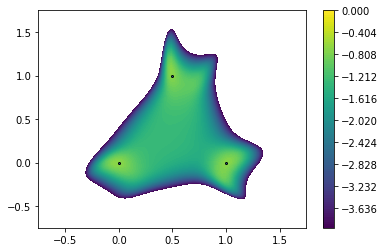

In [101]:
levels = np.linspace(-4, 0, 100)
plt.contourf(grid[:,:,0], grid[:,:,1], log_likelihoods, levels=levels)
plt.plot([0., 1., 0.5], [0., 0., 1.], "o", ms=2, markeredgecolor="k")
plt.colorbar()
plt.show()

In [102]:
!zip -r bnn_results_analysis.zip /content/runs 

  adding: content/runs/ (stored 0%)
  adding: content/runs/sgd/ (stored 0%)
  adding: content/runs/sgd/mlsst/ (stored 0%)
  adding: content/runs/sgd/mlsst/Y10/ (stored 0%)
  adding: content/runs/sgd/mlsst/Y10/posterior_visualization/ (stored 0%)
  adding: content/runs/sgd/mlsst/Y10/posterior_visualization/command.sh (deflated 62%)
  adding: content/runs/sgd/mlsst/Y10/posterior_visualization/surface_plot.npz (deflated 65%)
  adding: content/runs/sgd/mirabest/ (stored 0%)
  adding: content/runs/sgd/mirabest/confident/ (stored 0%)
  adding: content/runs/sgd/mirabest/confident/posterior_visualization/ (stored 0%)
  adding: content/runs/sgd/mirabest/confident/posterior_visualization/command.sh (deflated 64%)
  adding: content/runs/sgd/mirabest/confident/posterior_visualization/surface_plot.npz (deflated 66%)
  adding: content/runs/sgd/slc/ (stored 0%)
  adding: content/runs/sgd/slc/space/ (stored 0%)
  adding: content/runs/sgd/slc/space/posterior_visualization/ (stored 0%)
  adding: content

In [103]:
!cp /content/bnn_results_analysis.zip /content/drive/MyDrive